# Particle evolution

In the [growth](./growth.ipynb) and [falling](./falling.ipynb) notebooks we have 
recipes for calculating how quickly a given iron particle will grow, and how
fast it will fall, and we know that the growth rate depends on (among other things)
the thickness of a chemical boundary layer that is set by the falling velocity. Here
we consider the time evolution of the size and position of a particle falling through
a layer. We'll first sketch out an algorithm for this and illustrate it with a naive
but easy to follow implementation (using a forward Euler integrator). This implementation
turns out to be inefficient because the time step that is needed for accuracy changes
with the particle size so we then show the use of our preferred implementation
(which can be found in the `particle_evolution` python module. Finally, we show
how changing the key parameters changes the particles evolution when falling by
itself through a layer of fixed temperature, pressure and liquid composition. The same
code is ultimately used as a component of our model of the F-layer.

As ever, we start by loading some modules.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
%matplotlib inline

import particle_evolution
import feo_thermodynamics
import growth
import falling

## Forward Euler solution of a falling and growing particle

For this calculation we will imagine a particle falling through the F-layer with fixed
temperature, pressure, and liquid composition. The location, $R_p$ of
the particle at time $t$ depends on it's falling velocity, $V$ and is updated from time step $t^i$
to $t^{i+1}$ using: 

$$ R_p^{i+1} = R_p^i - V(r_p^i) \Delta t,$$

where the minus sign indicates a downward velocity, which depends on the particle size. Similarly, 
the particle radius, $r_p$, depends on the growth velocity, $G$ and is updated with:

$$ r_p^{i+1} = r_p^i + G\left(V(r_p^i)\right) \Delta t.$$

Our solution is constructed as follows for a given initial location and radius of the particle:

1. Calculate the falling velocity, Reynolds number and boundary layer thickness using the `falling` module, solid and liquid density and viscosity.
2. Calculate the growth rate using the `growth` module, using the falling velocity, boundary layer thickness, chemical diffusivity, and growth pre-factor.
3. Update the position and size of the particle

and this is repeated. We choose a 200 km thick layer at 5000 K, 330 GPa and with 5 mol. % oxygen. We start with quite a big particle
but end up limited by our time step.


/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


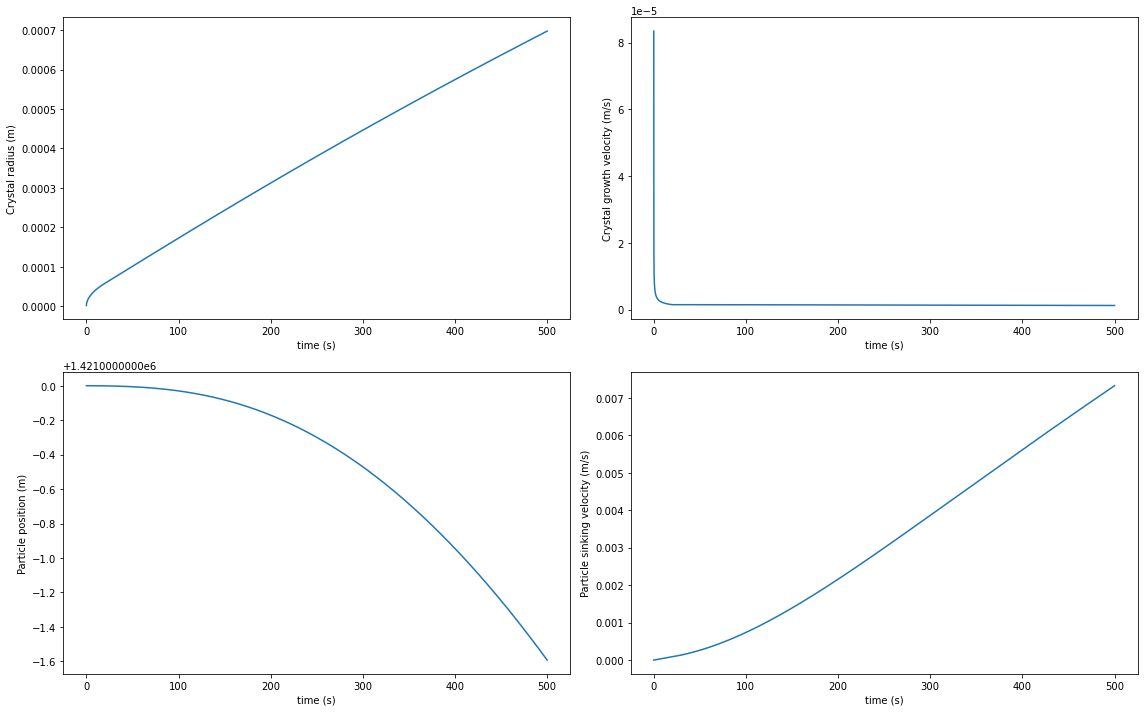

In [2]:
# Forward Euler solution for evolution in a box with 
# boundary layer that evolves as the particle falls

r0 = 1.0E-6 # initial radius, m
t = 5000.0 # temperature, K
p = 330.0 # GPa
x = 0.95 # Overall composition, mol frac Fe
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
radius_inner_core = 1221.0e3
radius_top_flayer = radius_inner_core + 200.0e3
mu = 1.0e-6 # kinematic viscosity
g = 3.7 # ICB gravity - from PREM

time_step = 1.0E-2 # s
total_time = 5.0E4 * time_step # s


rs = [] # List to store radii (of particle)
ts = [] # List to store times
gs = [] # List of growth velocites
ps = [] # Position of particle at each timestep
vs = [] # Falling velocity of particle

time = 0.0
rp = r0
pp = radius_top_flayer

while (time < total_time) and (pp > radius_inner_core):
    
    # Density calculation
    rho_liq, _, _, rho_hcp, _, _ = feo_thermodynamics.densities(x, p, t)
    delta_rho = rho_hcp - rho_liq

    # falling velocity and boundary layer thickness (we don't use themal diffusivity)
    falling_velocity, drag_coefficient, re, pe_t, pe_c, fr, \
        _, _, delta_c = falling.zhang_particle_dynamics(rp, 
            mu, g, delta_rho, rho_liq, 10.0, dl, warn_peclet=False)
    
    # growth rate
    growth_rate, xp = growth.diffusion_growth_velocity(x, delta_c, p, t, dl, k0)
       
    # Update position and radius
    time = time + time_step
    pp = pp - falling_velocity * time_step
    rp = rp + growth_rate * time_step
    
    # Store results
    ts.append(time)
    rs.append(rp)
    gs.append(growth_rate)
    ps.append(pp)
    vs.append(falling_velocity)
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10)) 
ax[0,0].plot(ts, rs)
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('Crystal radius (m)')

ax[0,1].plot(ts, gs)
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('Crystal growth velocity (m/s)')

ax[1,0].plot(ts, ps)
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('Particle position (m)')

ax[1,1].plot(ts, vs)
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('Particle sinking velocity (m/s)')

fig.tight_layout()
plt.show() 

## Solution using SciPy's ODE solver  

Playing with the code above shows that we need very different time steps for small particles and large
particles as the behavior changes with the boundary layer scaling due to the feedback between velocity and
growth rate. However, this is clearly just an initial value solution of a pair of coupled ordinary differential
equations. ScyPy has an ODE IVP solver that does everything we need including the implementation of variable
time step. 

An implementation of the above, using the SciPy ODE solver can be found in the `particle_evolution` module
and is illustrated below. The trick is to set up the problem as a single function that takes the time and 
an array of the particle radius and the particle position as input, and returns the change in radius and 
position with time (i.e. the growth rate and falling velocity). We also need to pass in the other arguments 
and set up a functions to check for the stop condition (e.g. if the particle hits the inner core). The whole 
lot then goes into the IVP solver.This uses RK45 (by default) to do the integration (using 5th order 
Runge-Kutta to do the integration and 4th order Runge-Kutta to estimate the error and 
choose the step size at each time step). Once we've got the solution at a minimum set of times
(and a nice smooth interpolation of the solution) we can evaluate the other values wherever we want.

Our function `particle_evolution.falling_growing_particle_solution` sets up and runs the IVP returning
a `solution` object. The function `particle_evolution.plot_particle_evolution_time` takes this object
and generates plots of the (interpolated) results.

/Users/andreww/Code/slurry/falling.py:66: UserWarning: Calculated Re 314454 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(
/Users/andreww/Code/slurry/falling.py:66: UserWarning: Calculated Re 306382 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


final radius: 0.25562121566198065 m falling time: 590102.9154566745 s


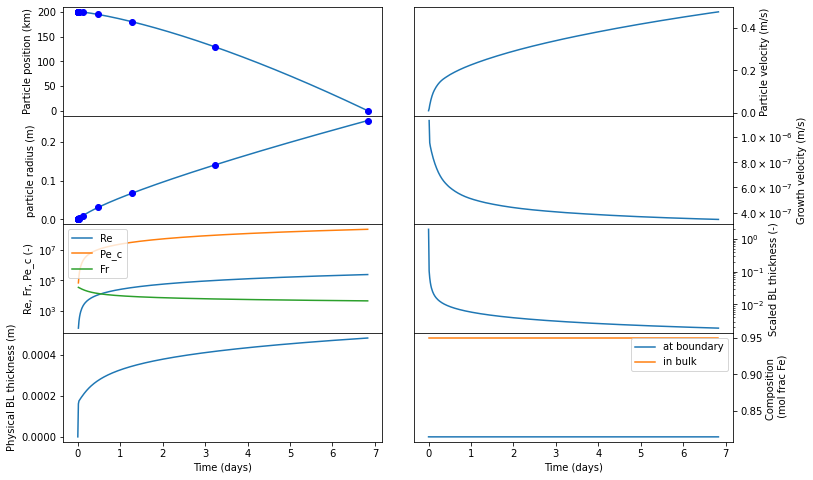

In [3]:
# Some input parameters

start_time = 0.0
max_time = 1.0E8
initial_particle_size = 1.0E-8
initial_particle_position = 200.0 * 1000.0
radius_inner_core = 0.1
xl = 0.95
t = 5000.0
p = 330.0
g = 5.0
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                      xl, t, p, dl, k0, g, mu, radius_inner_core, analysis_radii=None)

# Check solution
assert sol.status >= 0, "IVP failed"
assert sol.status == 1, "Out of time, did not hit ICB"

# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]
print(f"final radius: {sol.sol(times[-1])[0]} m falling time: {sol.sol.ts[-1]} s")

# Plot (does it's own interploation and evaluation of values.
particle_evolution.plot_particle_evolution_time(sol, xl, t, p, dl, k0, g, mu, 
                                 include_solution_points=True)


/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/Code/slurry/falling.py:66: UserWarning: Calculated Re 324061 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(
/Users/andreww/Code/slurry/falling.py:66: UserWarning: Calculated Re 315732 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


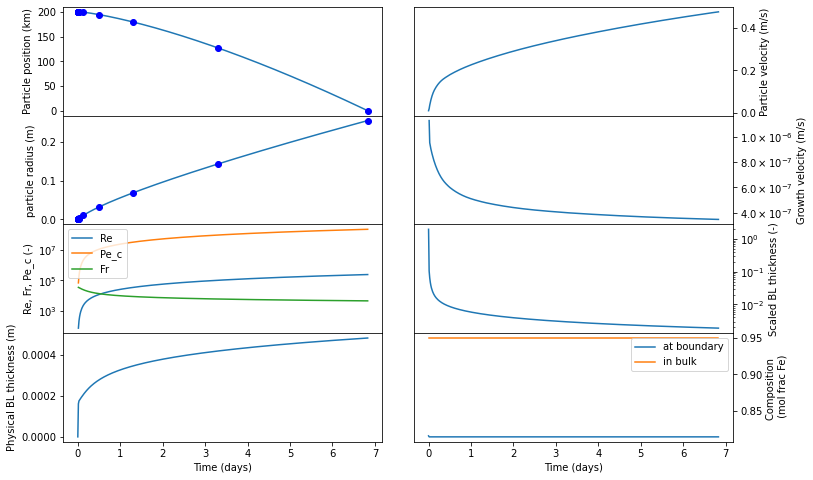

In [4]:
# Lower k0

start_time = 0.0
max_time = 1.0E8
initial_particle_size = 1.0E-8
initial_particle_position = 200.0 * 1000.0
radius_inner_core = 0.1
xl = 0.95
t = 5000.0
p = 330.0
g = 5.0
k0 = 5.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                      xl, t, p, dl, k0, g, mu, radius_inner_core, analysis_radii=None)

# Check solution
assert sol.status >= 0, "IVP failed"
assert sol.status == 1, "Out of time, did not hit ICB"

# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]

# Plot
particle_evolution.plot_particle_evolution_time(sol, xl, t, p, dl, k0, g, mu, 
                                 include_solution_points=True)

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


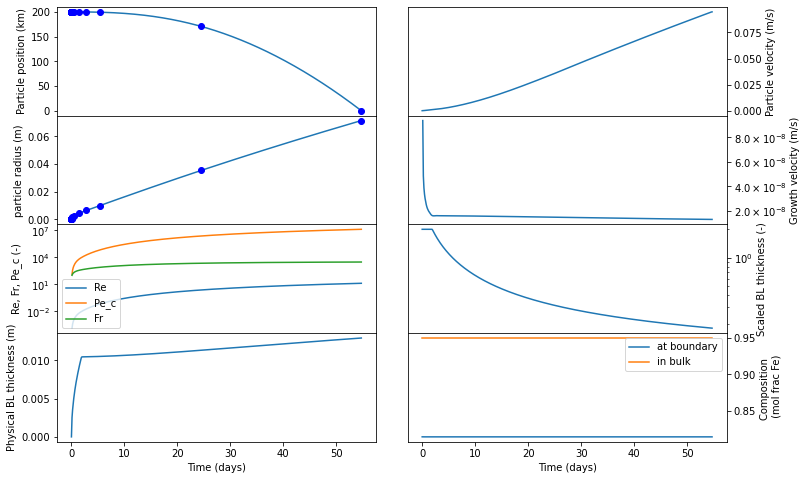

In [5]:
# Three orders of magnitude more viscous

start_time = 0.0
max_time = 1.0E8
initial_particle_size = 1.0E-8
initial_particle_position = 200.0 * 1000.0
radius_inner_core = 0.1
xl = 0.95
t = 5000.0
p = 330.0
g = 5.0
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-3 # kinematic viscosity

sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                      xl, t, p, dl, k0, g, mu, radius_inner_core, analysis_radii=None)

# Check solution
assert sol.status >= 0, "IVP failed"
assert sol.status == 1, "Out of time, did not hit ICB"

# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]

# plot
particle_evolution.plot_particle_evolution_time(sol, xl, t, p, dl, k0, g, mu, 
                                 include_solution_points=True)

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


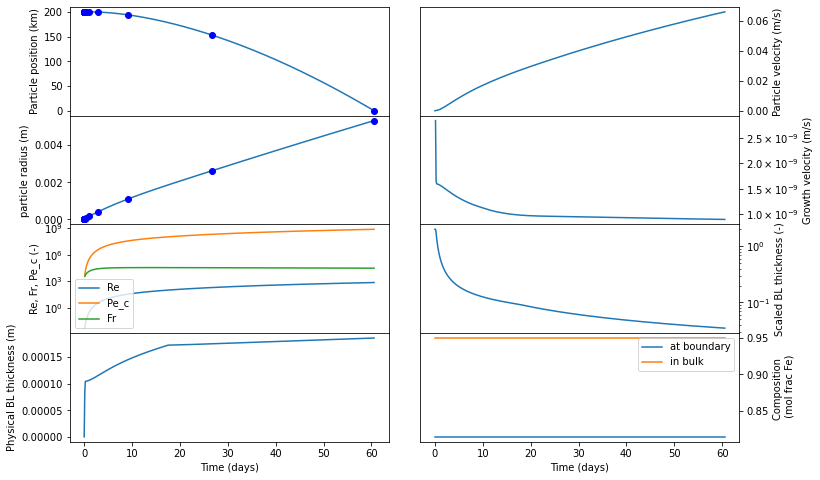

In [6]:
# Lower diffusivity (eventually you do see the regime change)

start_time = 0.0
max_time = 1.0E8
initial_particle_size = 1.0E-8
initial_particle_position = 200.0 * 1000.0
radius_inner_core = 0.1
xl = 0.95
t = 5000.0
p = 330.0
g = 5.0
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-12 # diffusion
mu = 1.0e-6 # kinematic viscosity

sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                      xl, t, p, dl, k0, g, mu, radius_inner_core, analysis_radii=None)

# Check solution
assert sol.status >= 0, "IVP failed"
assert sol.status == 1, "Out of time, did not hit ICB"

# Plot
particle_evolution.plot_particle_evolution_time(sol, xl, t, p, dl, k0, g, mu, 
                                 include_solution_points=True)

## Figure for the paper

We try to capture the above in a summary figure showing key information from some time serine and an overview of the behavior. 

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


No result for dl=1.00e-07, mu=1.58e-05, k0=1.50e+02: Calculated Re 307679 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=7.94e-06, k0=1.50e+02: Calculated Re 318898 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=3.98e-06, k0=1.50e+02: Calculated Re 312982 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=2.00e-06, k0=1.50e+02: Calculated Re 319106 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=1.00e-06, k0=1.50e+02: Calculated Re 311645 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=5.01e-07, k0=1.50e+02: Calculated Re 315729 too high for drag / velocity parameterisation. Treat results with care
No result for dl=1.00e-07, mu=2.51e-07, k0=1.50e+02: Calculated Re 414109 too high for drag / velocity parameterisation. Treat res

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


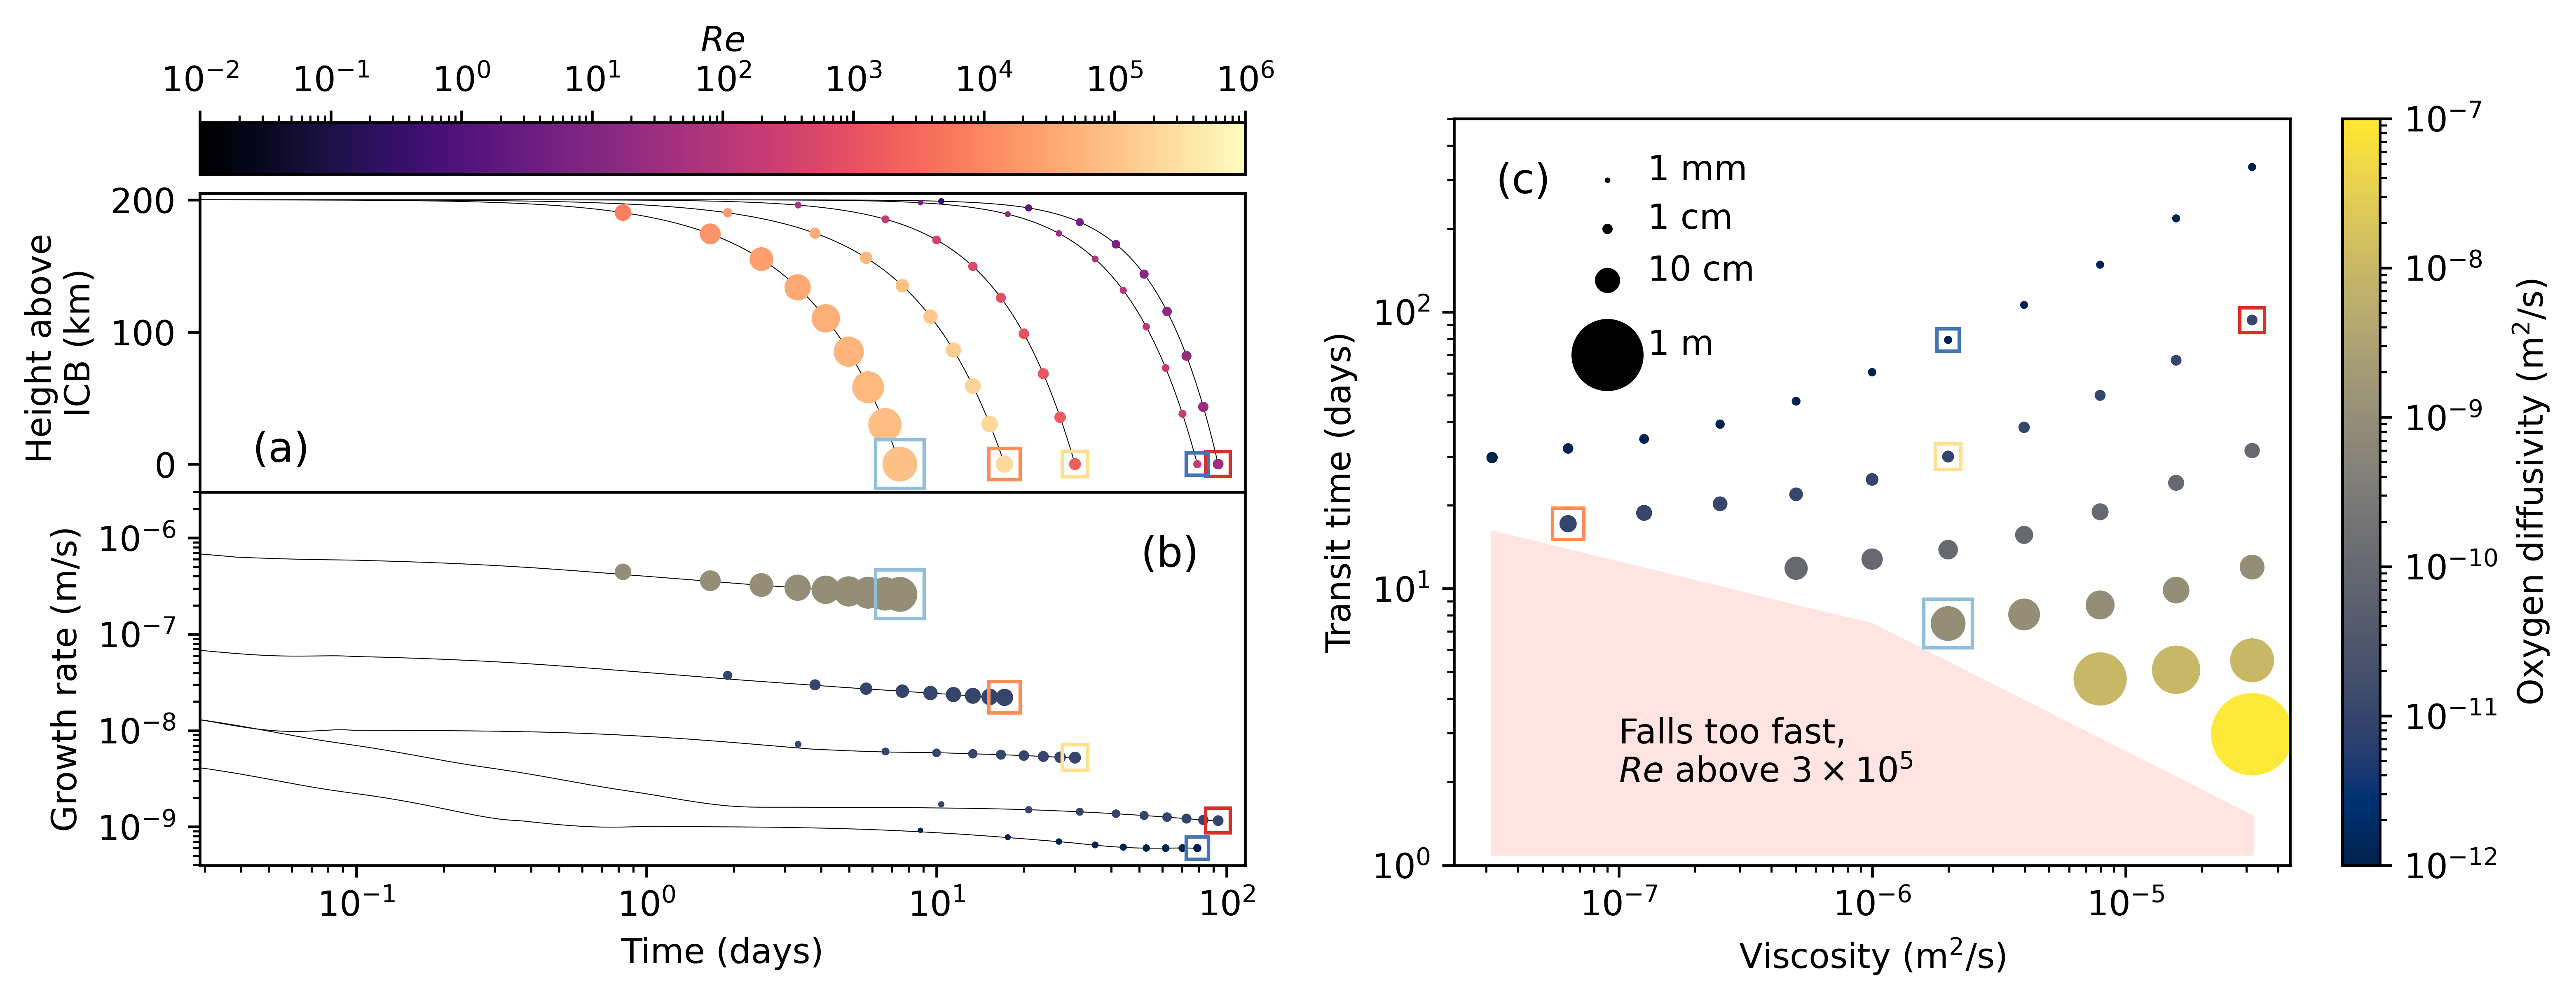

In [7]:
# How does falling time and final radius vary with parameters

import warnings
warnings.filterwarnings("error","",UserWarning)

# Default parameters
start_time = 0.0
max_time = 1.0E9
initial_particle_size = 1.0E-8
initial_particle_position = 200.0 * 1000.0
radius_inner_core = 0.1
xl = 0.95
t = 5000.0
p = 330.0
g = 5.0

# Parameters to vary
k0s = [150.0] # growth rate prefactor, m/s; value does not seem to matter for summary info (1.5 m/s plots on top)
dls = [1.0E-7, 1.0E-8, 1.0E-9, 1.0E-10, 1.0E-11, 1.0E-12] # diffusion
mus = np.logspace(-4.5, -7.5, num=11) # kinematic viscosity, if we go any more viscous it's too fast (high Ra) for all dls

final_size = np.zeros((len(dls), mus.size, len(k0s)))
falling_time = np.zeros((len(dls), mus.size, len(k0s)))
sols = np.empty((len(dls), mus.size, len(k0s)), dtype=object)

for i, dl in enumerate(dls):
    for j, mu in enumerate(mus):
        for k, k0 in enumerate(k0s):
            try:
                sol = particle_evolution.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                               initial_particle_position,
                                                               xl, t, p, dl, k0, g, mu, radius_inner_core, analysis_radii=None)
                final_size[i,j,k] = sol.y[0][-1]
                falling_time[i,j,k] = sol.t[-1]
                sols[i,j,k] = sol
            except UserWarning as w:
                # div by zero in bounday layer calc, or oo high Ra... don't want this value.
                final_size[i,j,k] = np.nan
                falling_time[i,j,k] = np.nan
                sols[i,j,k] = None
                print(f"No result for dl={dl:.2e}, mu={mu:.2e}, k0={k0:.2e}: {w}")


                
# Plotting params...
point_scale = 400 # px for particle of 1m size
timeserise_tuples = [(4,0,0), (4,9,0), (4,4,0), (2,4,0), (5,4,0)]
item_symbols = ['s','s','s','s','s']
item_colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
                
# Setup figure axes... big one on RHS, stacked times serise on LHS. See 
# https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/gridspec_and_subplots.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-and-subplots-py

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,4), dpi=600, sharex='col')
fig.subplots_adjust(hspace=0)
gs = axs[0, 1].get_gridspec()

# remove the underlying axes pair on RHS
for ax in axs[0:, 1]:
    ax.remove()

# Make new RHS axis
axr = fig.add_subplot(gs[0:, -1]) # Right plot
ax0 = axs[0,0] # Top time serise
ax1 = axs[1,0] # Bottom tome serise

# Do the plotting!

# RHS plot...
for i, dl in enumerate(dls):
    pc = axr.scatter(mus, falling_time[i,:,0]/(60*60*24), label=f"$D_l$ = {dl:.1E}",
                    marker='o', s=(final_size[i,:,0]*point_scale), 
                    c=np.ones_like(falling_time[i,:,0])*dl,
                    norm=mplc.LogNorm(vmin=min(dls), vmax=max(dls)),
                    cmap='cividis')

axr.text(1.0E-7, 2.0, 'Falls too fast, \n$Re$ above $3\\times10^5$') 
    
# Size scale
axr.scatter(0.9E-7, 3.0E2, s=0.001*point_scale, c='k')
axr.text(1.3E-7, 3.0E2, "1 mm")
axr.scatter(0.9E-7, 2.0E2, s=0.01*point_scale, c='k')
axr.text(1.3E-7, 2.0E2, "1 cm")
axr.scatter(0.9E-7, 1.3E2, s=0.1*point_scale, c='k')
axr.text(1.3E-7, 1.3E2, "10 cm")
axr.scatter(0.9E-7, 0.7E2, s=1.0*point_scale, c='k')
axr.text(1.3E-7, 0.7E2, "1 m")

axr.set_xscale('log')
axr.set_xlabel('Viscosity (m$^2$/s)')
axr.set_yscale('log')
axr.set_ylabel('Transit time (days)')
axr.set_ylim([1.0, 500.0])

fig.colorbar(pc, label='Oxygen diffusivity (m$^2$/s)', ax=axr)

# Timeserise plots

normer = mplc.LogNorm(vmin=1.0E-2, vmax=1.0E6)

for ii, serise in enumerate(timeserise_tuples):
    i = serise[0]
    j = serise[1]
    k = serise[2]
    
    times, radii, v_growth, positions, v_falling, re, pe_c, \
        fr, delta_c, _, xp = particle_evolution.interpolate_particle_evolution(sols[i,j,k], 
                                                                                xl, t, p, dls[i], k0s[k], g, mus[j], numpoints=10)

    re_points = ax0.scatter(times/(60*60*24), positions/1000.0, s=radii*point_scale, c=re, norm=normer, cmap='magma')
    ax1.scatter(times/(60*60*24), v_growth, norm=mplc.LogNorm(vmin=min(dls), vmax=max(dls)),
                c=np.ones_like(times)*dls[i], s=radii*point_scale, cmap='cividis')

    # Add smooth line
    times_s = np.linspace(sols[i,j,k].sol.ts[0], sols[i,j,k].sol.ts[-1], 500)
    positions_s = sols[i,j,k].sol(times_s)[1]
    _, _, v_growth_s, _, _, _, _, _, _, _, _ = particle_evolution.interpolate_particle_evolution(sols[i,j,k], 
                                                    xl, t, p, dls[i], k0s[k], g, mus[j], inttimes=np.geomspace(1.0E-4*60*60*24, sols[i,j,k].sol.ts[-1], 500))
    ax0.plot(times_s/(60*60*24), positions_s/1000.0, zorder=0, lw=0.25, c='k')
    ax1.plot(np.geomspace(1.0E-4*60*60*24, sols[i,j,k].sol.ts[-1], 500)/(60.0*60.0*24), v_growth_s, zorder=0, lw=0.25, c='k')
    
    # Higlight end points with squares to tie together
    axr.plot(mus[j], sols[i,j,k].sol.ts[-1]/(60*60*24), marker=item_symbols[ii], markerfacecolor='none', markeredgecolor=item_colors[ii], 
             ms=np.sqrt(radii[-1]*point_scale)+5)
    ax0.plot(times[-1]/(60*60*24), positions[-1]/1000.0, marker=item_symbols[ii], markerfacecolor='none', markeredgecolor=item_colors[ii], 
             ms=np.sqrt(radii[-1]*point_scale)+5)
    ax1.plot(times[-1]/(60*60*24), v_growth[-1], marker=item_symbols[ii], markerfacecolor='none', markeredgecolor=item_colors[ii], 
             ms=np.sqrt(radii[-1]*point_scale)+5)
    
ax0.set_xscale('log')
ax0.set_xlim(2.5E3/(60*60*24), 1.0E7/(60*60*24))
ax0.set_ylim(-21, 205)

ax1.set_yscale('log')
#ax1.set_ylim(0.6E-10, 3.0E-6)

ax1.set_xlabel('Time (days)')
ax0.set_ylabel('Height above \nICB (km)')
ax1.set_ylabel('Growth rate (m/s)')

ax0.annotate("(a)", xy=(0.05, 0.1), xycoords="axes fraction", fontsize='large')
ax1.annotate("(b)", xy=(0.9, 0.8), xycoords="axes fraction", fontsize='large')
axr.annotate("(c)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize='large')

axr.fill_between(np.logspace(-4.5, -7.5, num=3), [1.5, 7.4, 16], [1.1, 1.1, 1.1], color='mistyrose') 

fig.colorbar(re_points, location='top', ax=ax0, label='$Re$')



plt.show()